In [2]:
import os, glob, time, math, shutil
import numpy as np
import pandas as pd
import pandas.io.common
import matplotlib.pyplot as plt
%matplotlib inline
import astropy
from astropy.io import fits
from astropy.stats import sigma_clipped_stats as scs
from scipy.optimize import curve_fit
def LINEAR(X, A, B):
    return A + B*X

In [3]:
stacked_no = 34
STACKED_LIST = sorted(glob.glob('E:\\stacked\\stack%d\\*.fit.gz'%stacked_no))
HDR_g_LIST = sorted(glob.glob('E:\\single\\stack%d\\g\\ZSKY*.fit.gz'%(stacked_no)))
HDR_r_LIST = sorted(glob.glob('E:\\single\\stack%d\\r\\ZSKY*.fit.gz'%(stacked_no)))
HDR_i_LIST = sorted(glob.glob('E:\\single\\stack%d\\i\\ZSKY*.fit.gz'%(stacked_no)))

for i in range(len(HDR_g_LIST)):
    HDR_g_LIST[i] = HDR_g_LIST[i][:-26] + 'fpC' + HDR_g_LIST[i][-22:]
    HDR_r_LIST[i] = HDR_r_LIST[i][:-26] + 'fpC' + HDR_r_LIST[i][-22:]
    HDR_i_LIST[i] = HDR_i_LIST[i][:-26] + 'fpC' + HDR_i_LIST[i][-22:]

RA_STA, DEC_STA = list(range(len(STACKED_LIST))), list(range(len(STACKED_LIST)))
for i in range(len(STACKED_LIST)):    
    RA_STA[i] = fits.open(STACKED_LIST[i])[0].header[13]
    DEC_STA[i] = fits.open(STACKED_LIST[i])[0].header[12]

RA_g, DEC_g = list(range(len(HDR_g_LIST))), list(range(len(HDR_g_LIST)))
RA_r, DEC_r = list(range(len(HDR_r_LIST))), list(range(len(HDR_r_LIST)))
RA_i, DEC_i = list(range(len(HDR_i_LIST))), list(range(len(HDR_i_LIST)))

for i in range(len(HDR_g_LIST)):
    RA_g[i], DEC_g[i] = fits.open(HDR_g_LIST[i])[0].header[-6], fits.open(HDR_g_LIST[i])[0].header[-5]
    RA_r[i], DEC_r[i] = fits.open(HDR_r_LIST[i])[0].header[-6], fits.open(HDR_r_LIST[i])[0].header[-5]
    RA_i[i], DEC_i[i] = fits.open(HDR_i_LIST[i])[0].header[-6], fits.open(HDR_i_LIST[i])[0].header[-5]


In [4]:
STA_IMGS = np.zeros(len(STACKED_LIST)*1489*2048).reshape(len(STACKED_LIST),1489,2048)
for i in range(len(STACKED_LIST)):
    STA_IMGS[i] = fits.open(STACKED_LIST[i])[0].data

dpp = 0.00011  # degree per pixel
dcrp = 745  # distance from center ra pixel
dcdp = 1025 # distance from center dec pixel

radiff = np.zeros(len(RA_STA))
decdiff = np.zeros(len(RA_STA))

for i in range(len(RA_STA)):
    radiff[i] = int(round((RA_STA[i] - np.asarray([RA_g[i],RA_r[i],RA_i[i]]).min())/dpp))
    decdiff[i] = int(round((DEC_STA[i] - np.asarray([DEC_g[i],DEC_r[i],DEC_i[i]]).min())/dpp))    
    

for i in range(len(STACKED_LIST)):
    STA_CUT = STA_IMGS[i,64:-(int(radiff[i])+64),64:-(int(decdiff[i])+64)]
    STA_file = fits.PrimaryHDU(data=(STA_CUT+1000)/401000)
    STA_file.writeto('E:\\cGAN\\1k\\stacked\\stack%d\\STA-%s.fit'%(stacked_no, STACKED_LIST[i][-21:-7]))


In [7]:
band = 'i'
SINGLE_LIST = sorted(glob.glob('E:\\single\\stack%d\\%s\\ZSKY*.fit.gz'%(stacked_no,band)))

SIN_IMGS = np.zeros(len(SINGLE_LIST)*1489*2048).reshape(len(SINGLE_LIST),1489,2048)
for i in range(len(SINGLE_LIST)):
    SIN_IMGS[i] = fits.open(SINGLE_LIST[i])[0].data

for i in range(len(STACKED_LIST)):
    STA_CUT = STA_IMGS[i,64:-(int(radiff[i])+64),64:-(int(decdiff[i])+64)]
    #STA_file = fits.PrimaryHDU(data=(STA_CUT+1000)/401000)
    #STA_file.writeto('E:\\cGAN\\1k\\stacked\\stack%d\\STA-%s.fit'%(stacked_no, STACKED_LIST[i][-21:-7]))

    if band == 'g':
        SINGLE_CUT = SIN_IMGS[i,int(round((RA_STA[i] - RA_g[i])/dpp))+64:int(round((RA_STA[i] - RA_g[i])/dpp))+64+STA_CUT.shape[0]
                            ,int(round((DEC_STA[i] - DEC_g[i])/dpp))+64:int(round((DEC_STA[i] - DEC_g[i])/dpp))+64+STA_CUT.shape[1]]
    elif band == 'r':
        SINGLE_CUT = SIN_IMGS[i,int(round((RA_STA[i] - RA_r[i])/dpp))+64:int(round((RA_STA[i] - RA_r[i])/dpp))+64+STA_CUT.shape[0]
                              ,int(round((DEC_STA[i] - DEC_r[i])/dpp))+64:int(round((DEC_STA[i] - DEC_r[i])/dpp))+64+STA_CUT.shape[1]]
    elif band == 'i':
        SINGLE_CUT = SIN_IMGS[i,int(round((RA_STA[i] - RA_i[i])/dpp))+64:int(round((RA_STA[i] - RA_i[i])/dpp))+64+STA_CUT.shape[0]
                              ,int(round((DEC_STA[i] - DEC_i[i])/dpp))+64:int(round((DEC_STA[i] - DEC_i[i])/dpp))+64+STA_CUT.shape[1]]
    
    SIN_file = fits.PrimaryHDU(data=(SINGLE_CUT*4.957+1000)/401000)
    SIN_file.writeto('E:\\cGAN\\1k\\single\\stack%d\\%s\\SIN-%s.fit'%(stacked_no, band, SINGLE_LIST[i][-21:-7]))



(1176, 1910)


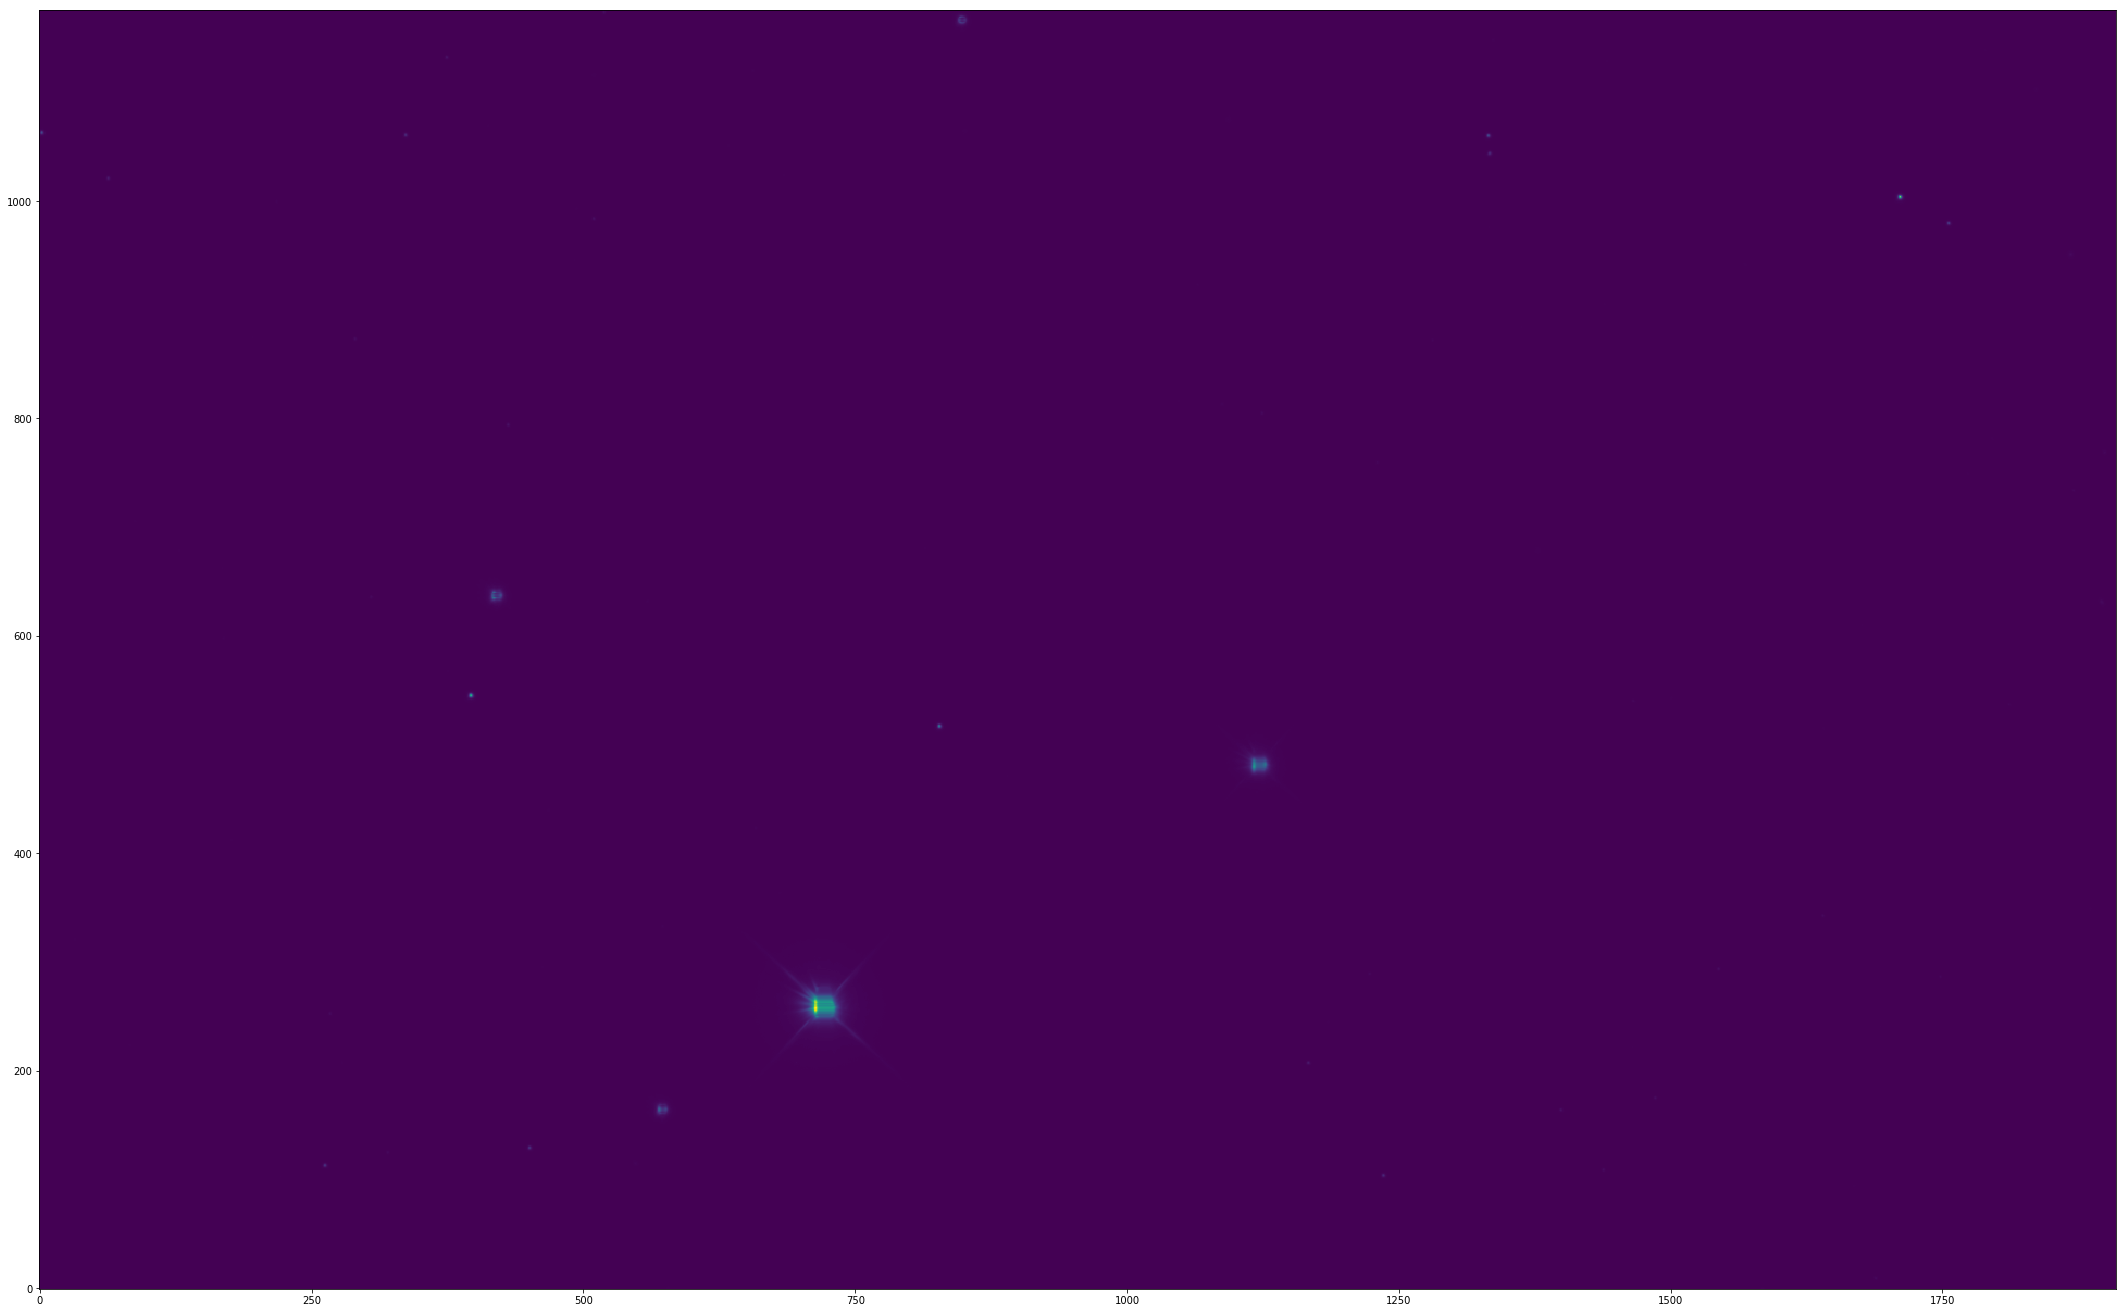

In [99]:
STA_TEST_CUT = STA_IMGS[64:-(int(radiff[i])+64),64:-(int(decdiff[i])+64)]


G_TEST_CUT = g_IMGS[int(round((RA_STA[0] - RA_g[0])/dpp))+64:int(round((RA_STA[0] - RA_g[0])/dpp))+64+STA_TEST_CUT.shape[0]
                    ,int(round((DEC_STA[0] - DEC_g[0])/dpp))+64:int(round((DEC_STA[0] - DEC_g[0])/dpp))+64+STA_TEST_CUT.shape[1]]
R_TEST_CUT = r_IMGS[int(round((RA_STA[0] - RA_r[0])/dpp))+64:int(round((RA_STA[0] - RA_r[0])/dpp))+64+STA_TEST_CUT.shape[0]
                    ,int(round((DEC_STA[0] - DEC_r[0])/dpp))+64:int(round((DEC_STA[0] - DEC_r[0])/dpp))+64+STA_TEST_CUT.shape[1]]
I_TEST_CUT = i_IMGS[int(round((RA_STA[0] - RA_i[0])/dpp))+64:int(round((RA_STA[0] - RA_i[0])/dpp))+64+STA_TEST_CUT.shape[0]
                    ,int(round((DEC_STA[0] - DEC_i[0])/dpp))+64:int(round((DEC_STA[0] - DEC_i[0])/dpp))+64+STA_TEST_CUT.shape[1]]

plt.imshow(R_TEST_CUT, origin='lower')
print(R_TEST_CUT.shape)

In [140]:
int(round(1000000000000.5))

1000000000000

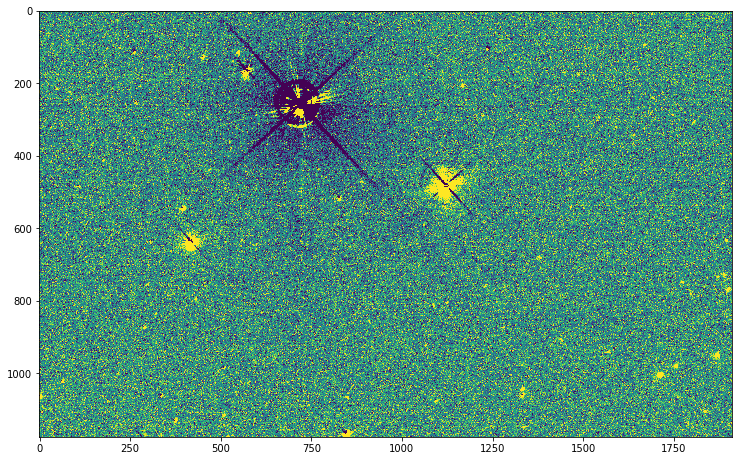

In [108]:
plt.rcParams['figure.figsize'] = (R_TEST_CUT.shape[1]/150, R_TEST_CUT.shape[0]/150)
TEST_IMG = STA_TEST_CUT - G_TEST_CUT*4.957
MEAN, MEDIAN, STD = scs(TEST_IMG)
nsigma = 2
plt.imshow(TEST_IMG, vmin = MEDIAN - nsigma*STD, vmax = MEDIAN + nsigma*STD)